In [ ]:
# One Stage Detector with one object

In [3]:
# Import libraries

import numpy as np
import tensorflow as tf
import cv2 as cv
import random
import matplotlib.pyplot as plt

In [4]:
# Generate training images and labels
N=4000
H,W=256,256

train_img=np.zeros([N,H,W,3],dtype=np.uint8)
train_img.fill(255)

train_label_coord=np.zeros([N,2],dtype=np.int32)
train_label_size=np.zeros([N,2],dtype=np.int32)
train_label_class=np.zeros([N,1],dtype=np.int32)

In [5]:
for n in range(N):
    x,y=random.randint(0,W-1),random.randint(0,H-1)
    bw,bh=random.randint(int(W/16),int(W/4)),random.randint(int(H/16),int(H/4))
    
    if(x-bw/2<0): x=x-(x-bw/2)
    elif(x+bw/2>W-1): x=x-(x+bw/2-(W-1))
    if(y-bh/2<0): y=y-(y-bh/2)
    elif(y+bh/2>H-1): y=y-(y+bh/2-(H-1))
    
    x=int(x); y=int(y)
    
    train_label_coord[n,0]=x; train_label_coord[n,1]=y
    train_label_size[n,0]=bw; train_label_size[n,1]=bh
    train_label_class[n]=random.randint(0,3) # 0: red, 1: green, 2: blue, 3: yellow
    
    if train_label_class[n]==0: # red
        cv.rectangle(train_img[n],(x-int(bw/2),y-int(bh/2)),(x+int(bw/2),y+int(bh/2)), color=(0,0,255), thickness=-1)
    elif train_label_class[n]==1: # green
        cv.rectangle(train_img[n],(x-int(bw/2),y-int(bh/2)),(x+int(bw/2),y+int(bh/2)), color=(0,255,0), thickness=-1)
    elif train_label_class[n]==2: # blue
        cv.rectangle(train_img[n],(x-int(bw/2),y-int(bh/2)),(x+int(bw/2),y+int(bh/2)), color=(255,0,0), thickness=-1)
    else: # yellow
        cv.rectangle(train_img[n],(x-int(bw/2),y-int(bh/2)),(x+int(bw/2),y+int(bh/2)), color=(255,255,0), thickness=-1)

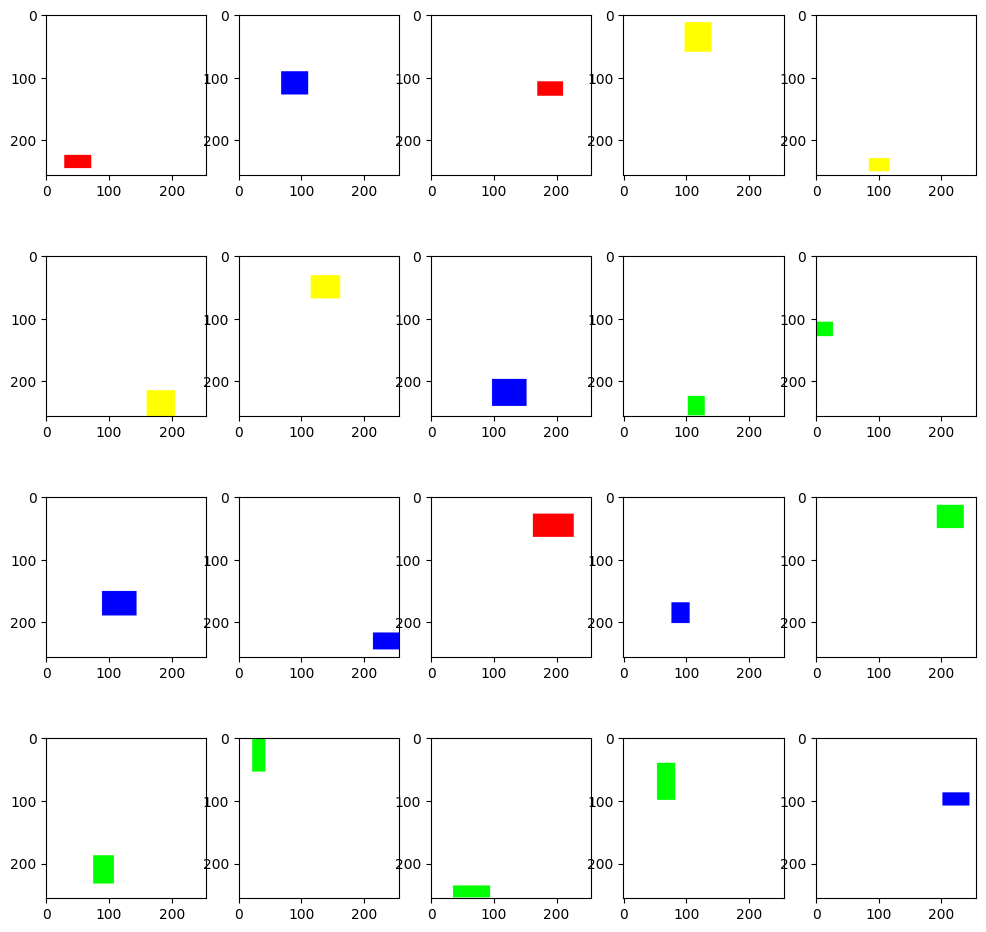

In [6]:
# Display some images

fig = plt.figure(figsize=(12,12))
rows=4
columns=5

for idx in range(1, columns * rows +1):
    fig.add_subplot(rows, columns, idx)
    plt.imshow(train_img[idx])

In [6]:
# Preprocess data
train_img = tf.keras.applications.vgg16.preprocess_input(train_img)
train_label_coord=train_label_coord.astype(np.float32)
train_label_coord[:,0]=train_label_coord[:,0]/W
train_label_coord[:,1]=train_label_coord[:,1]/H
train_label_size=train_label_size.astype(np.float32)
train_label_size[:,0]=train_label_size[:,0]/(W/4)
train_label_size[:,1]=train_label_size[:,1]/(H/4)

# Build model
base_model = tf.keras.applications.VGG16(input_shape=[H,W,3], include_top=False, weights='imagenet')
x = base_model.output
x = tf.keras.layers.Flatten()(x)

out_coord=tf.keras.layers.Dense(2,activation='sigmoid',name='out_coord')(x)
out_size=tf.keras.layers.Dense(2, activation='sigmoid',name='out_size')(x)
out_class=tf.keras.layers.Dense(4,activation='softmax',name='out_class')(x) # 클래스가 4개

model=tf.keras.Model(inputs=base_model.input,outputs=[out_coord,out_size,out_class])
model.summary()

I0000 00:00:1742857070.534213  350705 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6191 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:26:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 256, 256,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 128, 128,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 128, 128,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 128, 128,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 64, 64,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 64, 64,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 64, 64,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 64, 64,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 32, 32,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 32, 32,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 32, 32,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 32, 32,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 16, 16,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 16, 16,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 16, 16,    │  2,359,808 │ block5_conv1[0][

 Total params: 14,976,840 (57.13 MB)

 Trainable params: 14,976,840 (57.13 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Custom loss functions
def coord_loss_func(y_true,y_pred):
    loss_coord=tf.keras.losses.MSE(y_true,y_pred)
    return loss_coord

def size_loss_func(y_true,y_pred):
    loss_size=tf.keras.losses.MSE(y_true,y_pred)
    return loss_size
    
def class_loss_func(y_true,y_pred):  
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.one_hot(y_true, 4)
    y_true = tf.reshape(y_true, [-1,4])

    # One Hot Encoding을 한 경우 e.g. [0,0,1,0] : categorical_crossentropy, 그렇지 않은 경우 (e.g. [3,0,1] : spare_categorical_crossentropy 
    loss_class=tf.keras.losses.categorical_crossentropy(y_true,y_pred)
    return loss_class

In [8]:
# Train and save model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss={'out_coord':coord_loss_func,'out_size':size_loss_func,'out_class':class_loss_func},
    loss_weights={'out_coord':3,'out_size':2,'out_class':2})

history = model.fit(x=train_img,
    y={'out_coord':train_label_coord,'out_size':train_label_size,'out_class':train_label_class},
    epochs=20,batch_size=10,validation_split=0.25)
model.save('model.keras')

2025-03-25 07:57:52.218111: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2359296000 exceeds 10% of free system memory.
2025-03-25 07:57:53.529792: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2359296000 exceeds 10% of free system memory.


Epoch 1/20


I0000 00:00:1742857076.415490  350950 service.cc:152] XLA service 0x7f7138001ed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742857076.415522  350950 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2025-03-25 07:57:56.467067: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742857076.811946  350950 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/300 ━━━━━━━━━━━━━━━━━━━━ 57:20 12s/step - loss: 12.1666 - out_class_loss: 5.5764 - out_coord_loss: 0.2472 - out_size_loss: 0.1361

I0000 00:00:1742857085.895916  350950 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 ━━━━━━━━━━━━━━━━━━━━ 50s 127ms/step - loss: 2.1194 - out_class_loss: 0.8867 - out_coord_loss: 0.0580 - out_size_loss: 0.0861 - val_loss: 0.1579 - val_out_class_loss: 0.0075 - val_out_coord_loss: 0.0144 - val_out_size_loss: 0.0498
Epoch 2/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 35s 117ms/step - loss: 0.0842 - out_class_loss: 0.0029 - out_coord_loss: 0.0070 - out_size_loss: 0.0286 - val_loss: 0.0215 - val_out_class_loss: 6.8020e-04 - val_out_coord_loss: 0.0025 - val_out_size_loss: 0.0062
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 35s 118ms/step - loss: 0.0175 - out_class_loss: 4.8274e-04 - out_coord_loss: 0.0022 - out_size_loss: 0.0049 - val_loss: 0.0116 - val_out_class_loss: 2.6681e-04 - val_out_coord_loss: 0.0013 - val_out_size_loss: 0.0035
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 36s 119ms/step - loss: 0.0091 - out_class_loss: 2.4774e-04 - out_coord_loss: 0.0011 - out_size_loss: 0.0027 - val_loss: 0.0071 - val_out_class_loss: 1.9722e-04 - val_out_coord_loss: 8.2887e-04 - val_out_size_loss

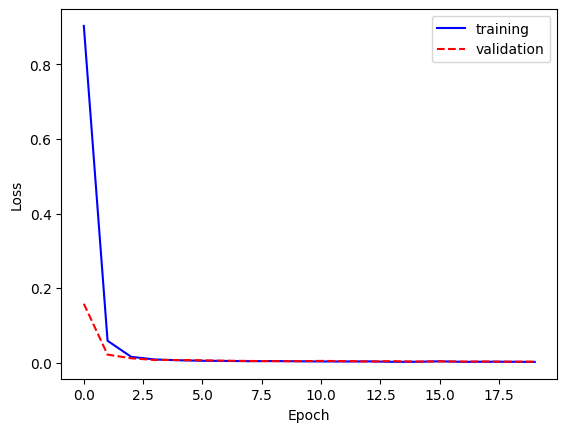

In [9]:
# Show training history
plt.figure()
plt.plot(history.history['loss'], 'b-', label='training')
plt.plot(history.history['val_loss'], 'r--', label='validation')
plt.xlabel('Epoch'), plt.ylabel('Loss'), plt.legend()
plt.show()

In [21]:
# Generate test images and labels
N=20
H,W=256,256

test_img=np.zeros([N,H,W,3],dtype=np.uint8)
test_img.fill(255)
test_label_coord=np.zeros([N,2],dtype=np.int32)
test_label_size=np.zeros([N,2],dtype=np.int32)
test_label_class=np.zeros([N,1],dtype=np.int32) # 출력 라벨 클래스가 4개

In [22]:
for n in range(N):
    x,y=random.randint(0,W-1),random.randint(0,H-1)
    bw,bh=random.randint(int(W/16),int(W/4)),random.randint(int(H/16),int(H/4))
    
    if(x-bw/2<0): x=x-(x-bw/2)
    elif(x+bw/2>W-1): x=x-(x+bw/2-(W-1))
    if(y-bh/2<0): y=y-(y-bh/2)
    elif(y+bh/2>H-1): y=y-(y+bh/2-(H-1))
    
    x=int(x); y=int(y)
    
    test_label_coord[n,0]=x; test_label_coord[n,1]=y
    test_label_size[n,0]=bw; test_label_size[n,1]=bh
    test_label_class[n]=random.randint(0,3) # 0: red, 1: green, 2: blue, 3: yellow
    
    if test_label_class[n]==0: # red
        cv.rectangle(test_img[n],(x-int(bw/2),y-int(bh/2)),(x+int(bw/2),y+int(bh/2)), color=(0,0,255), thickness=-1)
    elif test_label_class[n]==1: # green
        cv.rectangle(test_img[n],(x-int(bw/2),y-int(bh/2)),(x+int(bw/2),y+int(bh/2)), color=(0,255,0), thickness=-1)
    elif test_label_class[n]==2: # blue
        cv.rectangle(test_img[n],(x-int(bw/2),y-int(bh/2)),(x+int(bw/2),y+int(bh/2)), color=(255,0,0), thickness=-1)
    else: # yellow
        cv.rectangle(test_img[n],(x-int(bw/2),y-int(bh/2)),(x+int(bw/2),y+int(bh/2)), color=(255,255,0), thickness=-1)

In [24]:
# Preprocess test images
test_img_ = tf.keras.applications.vgg16.preprocess_input(test_img)
# Predict object locations in test images
model=tf.keras.models.load_model('model.keras', custom_objects={'coord_loss_func':coord_loss_func,
                                                          'size_loss_func':size_loss_func, 'class_loss_func':class_loss_func})

pred_coord,pred_size,pred_class=model.predict(test_img_)
pred_coord[:,0]=pred_coord[:,0]*H
pred_coord[:,1]=pred_coord[:,1]*W
pred_size[:,0]=pred_size[:,0]*(H/4)
pred_size[:,1]=pred_size[:,1]*(W/4)
pred_class=np.argmax(pred_class,axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


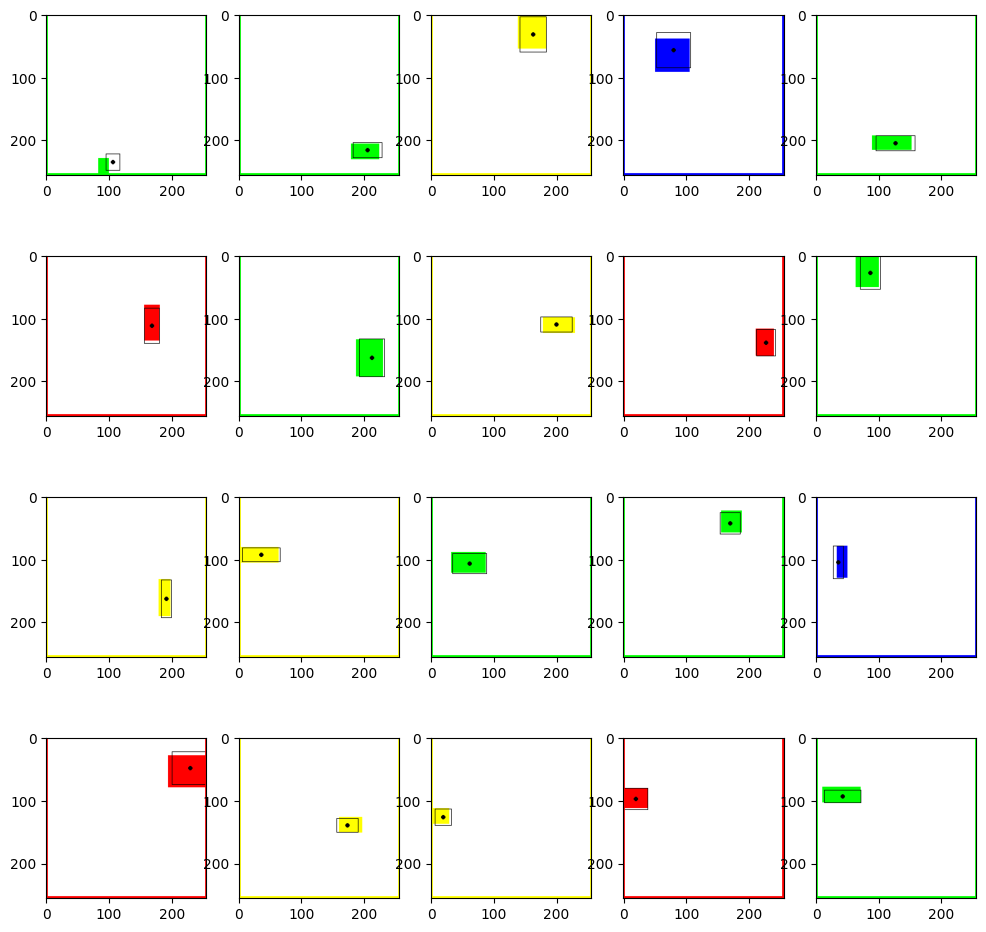

In [29]:
# Display prediction results

fig = plt.figure(figsize=(12, 12))
rows = 4
columns=5

for n in range(N):
    x=pred_coord[n,0].astype('int')
    y=pred_coord[n,1].astype('int')
    bw=pred_size[n,0].astype('int')
    bh=pred_size[n,1].astype('int')
    
    obj_class=pred_class[n]
    
    if obj_class==0: # red
        cv.rectangle(test_img[n],(x-int(bw/2),y-int(bh/2)),(x+int(bw/2),y+int(bh/2)),color=(0,0,0),thickness=1)
        cv.rectangle(test_img[n],(0,0),(W-1,H-1),color=(0,0,255),thickness=4)
    elif obj_class==1: # green
        cv.rectangle(test_img[n],(x-int(bw/2),y-int(bh/2)),(x+int(bw/2),y+int(bh/2)), color=(0,0,0),thickness=1)
        cv.rectangle(test_img[n],(0,0),(W-1,H-1),color=(0,255,0),thickness=4)
    elif obj_class==2: # blue
        cv.rectangle(test_img[n],(x-int(bw/2),y-int(bh/2)),(x+int(bw/2),y+int(bh/2)),color=(0,0,0),thickness=1)
        cv.rectangle(test_img[n],(0,0),(W-1,H-1),color=(255,0,0),thickness=4)
    else : # yellow
        cv.rectangle(test_img[n],(x-int(bw/2),y-int(bh/2)),(x+int(bw/2),y+int(bh/2)),color=(0,0,0),thickness=1)
        cv.rectangle(test_img[n],(0,0),(W-1,H-1),color=(255,255,0),thickness=4)
                                 
    cv.circle(test_img[n],center=(x,y),radius=2,color=(0,0,0),thickness=2)
    fig.add_subplot(rows, columns, n+1)
    plt.imshow(test_img[n])